# Imports

In [103]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

In [104]:
input_df = pd.read_csv('cookie_cats.csv')
input_df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


# Clean Data

In [105]:
clean_df = input_df.copy()
clean_df['COHORT'] = np.where(clean_df['version'] == 'gate_30', 'CONTROL', 'VARIATION')
clean_df['retention_1'] = np.where(clean_df['retention_1'] == True, 1.0, 0.0)
clean_df['retention_7'] = np.where(clean_df['retention_7'] == True, 1.0, 0.0)
round_threshold = clean_df['sum_gamerounds'].quantile(0.75)
clean_df['NUM_ROUNDS_CAT'] = clean_df['sum_gamerounds'].apply(
    lambda x: 'HIGH' if x > round_threshold else 'NORMAL'
)

clean_df = clean_df.drop(columns=['version', 'sum_gamerounds'])
clean_df = clean_df.rename(columns={
    'userid':'USER_ID',
    'retention_1':'RETENTION_ONE',
    'retention_7':'RETENTION_SEVEN'})
clean_df.head()

,USER_ID,RETENTION_ONE,RETENTION_SEVEN,COHORT,NUM_ROUNDS_CAT
0,116,0.0,0.0,CONTROL,NORMAL
1,337,1.0,0.0,CONTROL,NORMAL
2,377,1.0,0.0,VARIATION,HIGH
3,483,0.0,0.0,VARIATION,NORMAL
4,488,1.0,1.0,VARIATION,HIGH


# Define Metrics/Dimensions

In [106]:
metric_type_dict = {
    # 'NUM_ROUNDS': 'CONTINUOUS',
    'RETENTION_ONE': 'BINARY',
    'RETENTION_SEVEN': 'BINARY',
}

metric_human_readable = {
    # 'NUM_ROUNDS': 'Number of Rounds per Player',
    'RETENTION_ONE': 'Retention Rate (1 day)',
    'RETENTION_SEVEN': 'Retention Rate (7 Day)',
}

metric_list = list(metric_type_dict.keys())

dimension_list = ['NUM_ROUNDS_CAT']

# Define Functions

In [107]:
# Finds sample sizes for each cohort
def find_sample_sizes(input_df, cohort_column, user_column):
    # Count number of visits per cohort
    sample_size_groupby = input_df.copy().groupby(by=cohort_column)[user_column].count()

    # Try to extract sample sizes for each group; fallback to 0 if cohort missing
    try:
        sample_size_target = sample_size_groupby['VARIATION']
    except:
        sample_size_target = 0
    try:
        sample_size_control = sample_size_groupby['CONTROL']
    except:
        sample_size_control = 0

    return [sample_size_target, sample_size_control]

# Calculates mean and 95th percentile values for each metric, split by cohort
def calculate_raw_values(input_df, metric_list, cohort_column):
    summary = []

    for metric in metric_list:
        control_data = input_df[input_df[cohort_column] == 'CONTROL'][metric].dropna()
        variation_data = input_df[input_df[cohort_column] == 'VARIATION'][metric].dropna()

        summary.append({
            'metric': metric,
            'control_mean': control_data.mean(),
            'control_95th_percentile': control_data.quantile(0.95),
            'variation_mean': variation_data.mean(),
            'variation_95th_percentile': variation_data.quantile(0.95)
        })

    return summary

# Runs appropriate statistical tests (U-test or z-test) and returns p-values
def generate_p_values(input_df, metric_list):
    from statsmodels.stats.proportion import proportions_ztest
    import scipy
    
    sample_size_list = find_sample_sizes(
        input_df = input_df,
        cohort_column = 'COHORT',
        user_column = 'USER_ID'
    )
    
    p_value_array = []

    for metric in metric_list:

        # Use Mann-Whitney U-test for non-parametric numeric comparison
        if metric_type_dict[metric] == 'CONTINUOUS':
            stat_sig_test = scipy.stats.mannwhitneyu(
                input_df[input_df.COHORT == 'VARIATION'][metric],
                input_df[input_df.COHORT == 'CONTROL'][metric]
            )

        # Use Z-test for proportions for binary/completion events
        if metric_type_dict[metric] == 'BINARY':
            temp_groupby = input_df.groupby(by='COHORT')[[metric]].agg(
                visits=(metric, 'sum'),
                size=(metric, 'count')
            )
            stat_sig_test = proportions_ztest(
                [
                    temp_groupby.at['VARIATION', 'visits'],
                    temp_groupby.at['CONTROL', 'visits']
                ],
                [
                    temp_groupby.at['VARIATION', 'size'],
                    temp_groupby.at['CONTROL', 'size']
                ]
            )

        p_value_array.append({
            'metric': metric,
            'p_value': stat_sig_test[1]  # second value is the p-value
        })

    return p_value_array

# Uses bootstrapping to calculate confidence intervals for percent lift
def generate_confidence_intervals(input_df, metric_list, cohort_col='COHORT', groups=('CONTROL', 'VARIATION'),
                                  n_bootstraps=1000, conf_level=0.95, seed=None):
    if seed is not None:
        np.random.seed(seed)

    percent_lifts = {metric: [] for metric in metric_list}
    cohort_means = {metric: {group: [] for group in groups} for metric in metric_list}

    # Bootstrap loop
    for _ in range(n_bootstraps):
        sample_df = input_df.sample(frac=1, replace=True)

        for metric in metric_list:
            group_means = {}
            for group in groups:
                data = sample_df[sample_df[cohort_col] == group][metric].dropna()
                group_means[group] = data.mean()
                cohort_means[metric][group].append(group_means[group])

            # Calculate percent lift (variation vs. control)
            control_mean = group_means[groups[0]]
            variation_mean = group_means[groups[1]]

            if control_mean != 0:
                lift = (variation_mean - control_mean) / control_mean
                percent_lifts[metric].append(lift)
            else:
                percent_lifts[metric].append(np.nan)

    # Compile results into a DataFrame
    rows = []
    for metric in metric_list:
        lifts = np.array(percent_lifts[metric])
        lifts = lifts[~np.isnan(lifts)]

        lower = np.percentile(lifts, (1 - conf_level) / 2 * 100)
        upper = np.percentile(lifts, (1 + conf_level) / 2 * 100)

        rows.append({
            'metric': metric,
            f'percent_lift_ci_{int(conf_level * 100)}_lower': lower,
            f'percent_lift_ci_{int(conf_level * 100)}_upper': upper,
            'lifts_array': lifts
        })

    return rows

# Overall Results

## Raw Values

In [108]:
raw_values = calculate_raw_values(
    input_df = clean_df,
    metric_list = metric_list,
    cohort_column = 'COHORT'
)

for row in raw_values:
    print("Analyzing %s" % metric_human_readable[row['metric']])
    percent_diff = (row['variation_mean'] - row['control_mean']) / row['control_mean']
    print("   %.1f%% difference between variation and control means (%.2f vs %.2f)" % (percent_diff*100, row['variation_mean'], row['control_mean']))
    if metric_type_dict[row['metric']] == 'CONTINUOUS':
        percent_diff_percentile = (row['variation_95th_percentile'] - row['control_95th_percentile']) / row['control_95th_percentile']
        print("   %.1f%% difference between variation and control 95th percentiles (%.2f vs %.2f)" % (percent_diff_percentile*100, row['variation_95th_percentile'], row['control_95th_percentile']))
    print("")
        

Analyzing Retention Rate (1 day)
   -1.3% difference between variation and control means (0.44 vs 0.45)

Analyzing Retention Rate (7 Day)
   -4.3% difference between variation and control means (0.18 vs 0.19)



## P values

In [109]:
p_values = generate_p_values(
    input_df = clean_df,
    metric_list = metric_list
)

for row in p_values:
    print("Analyzing %s" % metric_human_readable[row['metric']])
    if row['p_value'] <= 0.05:
        stat_sig_string = 'Statistically Significant'
    else:
        stat_sig_string = 'NOT Statistically Significant'
    print("   Result: %s (P Value: %.4f)" % (stat_sig_string, row['p_value']))
    print("")

Analyzing Retention Rate (1 day)
   Result: NOT Statistically Significant (P Value: 0.0744)

Analyzing Retention Rate (7 Day)
   Result: Statistically Significant (P Value: 0.0016)



## Confidence Intervals

Analyzing Retention Rate (1 day)
   Result: NOT Statistically Significant (-2.76% : 0.07%)

Analyzing Retention Rate (7 Day)
   Result: Statistically Significant (-6.92% : -1.64%)



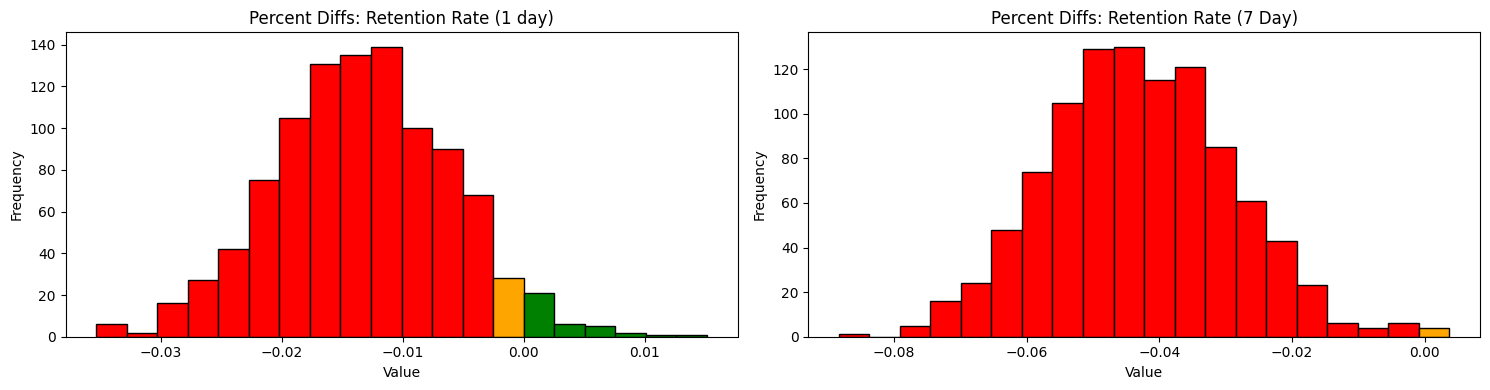

In [110]:
confidence_interval_values = generate_confidence_intervals(
    input_df = clean_df,
    metric_list = metric_list
)

fig, ax = plt.subplots(1,len(metric_list), figsize=(15,4))

for row_num, row in enumerate(confidence_interval_values, start=0):
    print("Analyzing %s" % metric_human_readable[row['metric']])
    if ((row['percent_lift_ci_95_lower'] > 0) & (row['percent_lift_ci_95_upper'] > 0)) | ((row['percent_lift_ci_95_lower'] < 0) & (row['percent_lift_ci_95_upper'] < 0)):
        stat_sig_string = 'Statistically Significant'
    else:
        stat_sig_string = 'NOT Statistically Significant'
    print("   Result: %s (%.2f%% : %.2f%%)" % (stat_sig_string, row['percent_lift_ci_95_lower']*100, row['percent_lift_ci_95_upper']*100))
    print("")
    
    counts, bin_edges = np.histogram(row['lifts_array'], bins=20)
    for i in range(len(counts)):
        left = bin_edges[i]
        right = bin_edges[i + 1]
        center = (left + right) / 2
        width = right - left
        if right < 0:
            color = 'red'      # Entire bin is below 0
        elif left > 0:
            color = 'green'    # Entire bin is above 0
        else:
            color = 'orange'   # Bin crosses 0
        ax[row_num].bar(center, counts[i], width=width, color=color, edgecolor='black', align='center')
    ax[row_num].set_title('Percent Diffs: %s' % metric_human_readable[row['metric']])
    ax[row_num].set_xlabel('Value')
    ax[row_num].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


## Summary

In [111]:
results_df = pd.DataFrame(raw_values).merge(pd.DataFrame(p_values), on='metric', how='inner')
results_df = results_df.merge(pd.DataFrame(confidence_interval_values), on='metric', how='inner')

results_df = results_df[['metric', 'control_mean', 'variation_mean', 'p_value', 'percent_lift_ci_95_lower', 'percent_lift_ci_95_upper']]
results_df['metric_human_readable']  = results_df.metric.apply(lambda x: metric_human_readable[x])

stat_sig_results_df = results_df[results_df.p_value < 0.05]
not_stat_sig_results_df = results_df[results_df.p_value >= 0.05]

if len(stat_sig_results_df) > 0:
    print("The experiment had a statistically significant impact on %d of our metric(s): %s" % (len(stat_sig_results_df), str(stat_sig_results_df['metric_human_readable'].to_list())))
    print("Therefore the expected impact of pushing this change live would be:")
    for index, row in stat_sig_results_df.iterrows():
        print("   %s: (%.2f%% : %.2f%%)" % (row['metric_human_readable'], row['percent_lift_ci_95_lower']*100, row['percent_lift_ci_95_upper']*100))
if len(not_stat_sig_results_df) > 0:
    print("\nWe cannot tell whether the variation would affect the following metric(s): %s" % (str(not_stat_sig_results_df['metric_human_readable'].to_list())))
    

The experiment had a statistically significant impact on 1 of our metric(s): ['Retention Rate (7 Day)']
Therefore the expected impact of pushing this change live would be:
   Retention Rate (7 Day): (-6.92% : -1.64%)

We cannot tell whether the variation would affect the following metric(s): ['Retention Rate (1 day)']


# Results by Dimension

Analyzing NORMAL Players (based on NUM_ROUNDS_CAT)
   The experiment had a statistically significant impact on 2 of our metric(s): ['Retention Rate (1 day)', 'Retention Rate (7 Day)']
   Therefore the expected impact of pushing this change live would be:
      Retention Rate (1 day): (-5.42% : -0.84%) - P Value: 0.01
      Retention Rate (7 Day): (-15.89% : -5.38%) - P Value: 0.00

Analyzing HIGH Players (based on NUM_ROUNDS_CAT)
   The experiment had a statistically significant impact on 2 of our metric(s): ['Retention Rate (1 day)', 'Retention Rate (7 Day)']
   Therefore the expected impact of pushing this change live would be:
      Retention Rate (1 day): (-2.15% : -0.07%) - P Value: 0.03
      Retention Rate (7 Day): (-6.49% : -2.28%) - P Value: 0.00

Histograms of % differences can be found below


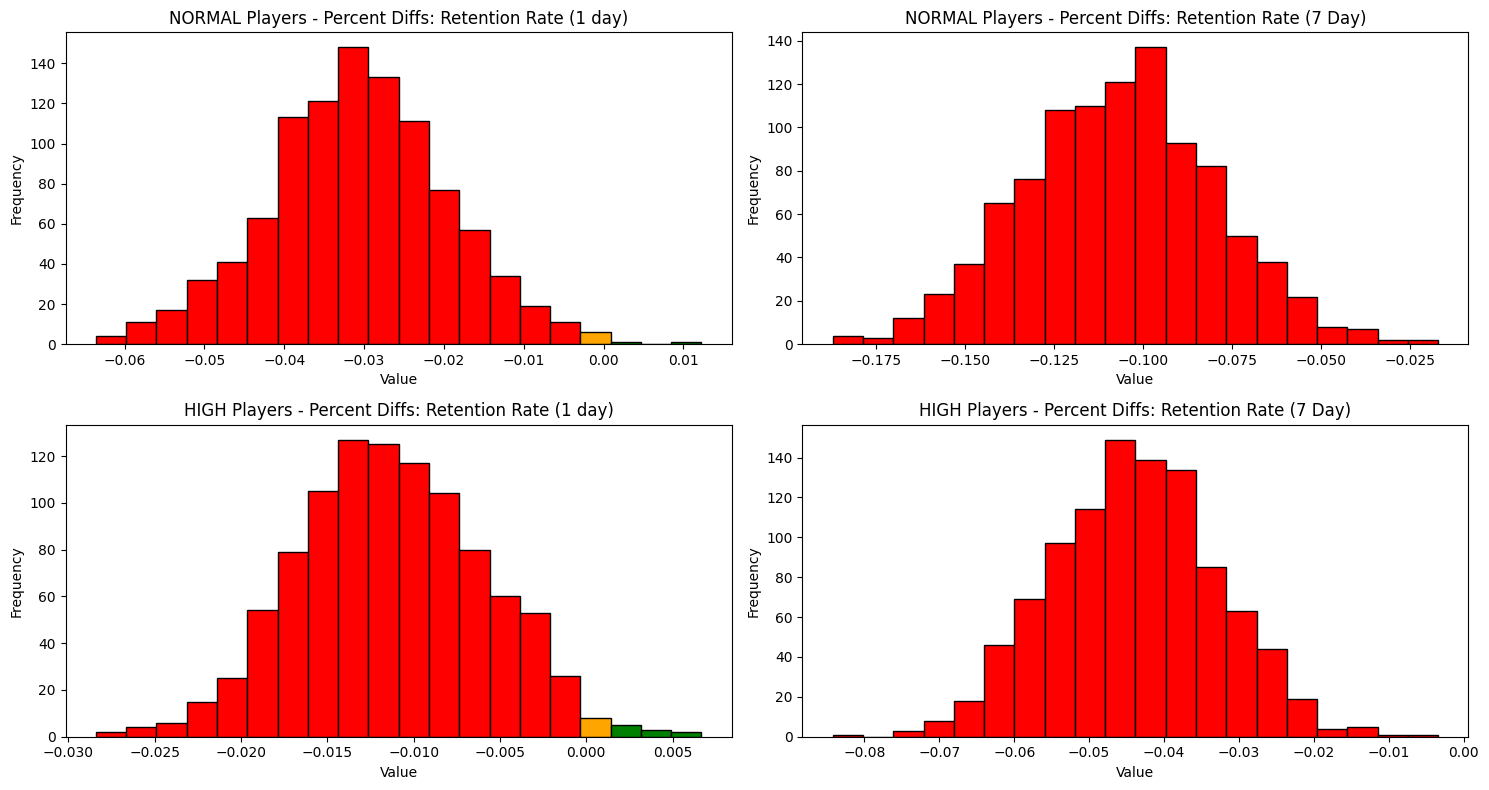

In [119]:
num_dimensions = len(dimension_list)
num_rows_chart = 0
for dimension in dimension_list:
    num_rows_chart = num_rows_chart + len(clean_df[dimension].unique())

fig, ax = plt.subplots(num_rows_chart,len(metric_list), figsize=(15,4*num_rows_chart))

chart_row = 0

for dimension in dimension_list:
    for dimension_value in clean_df[dimension].unique():
        print("Analyzing %s Players (based on %s)" % (dimension_value, dimension))
        temp_df = clean_df[clean_df[dimension] == dimension_value]
        temp_raw_values = calculate_raw_values(
            input_df = temp_df,
            metric_list = metric_list,
            cohort_column = 'COHORT'
        )
        temp_p_values = generate_p_values(
            input_df = temp_df,
            metric_list = metric_list
        )
        
        temp_confidence_interval_values = generate_confidence_intervals(
            input_df = temp_df,
            metric_list = metric_list
        )
        
        temp_results_df = pd.DataFrame(temp_raw_values).merge(pd.DataFrame(temp_p_values), on='metric', how='inner')
        temp_results_df = temp_results_df.merge(pd.DataFrame(temp_confidence_interval_values), on='metric', how='inner')
        
        chart_column = 0
        for index, row in temp_results_df.iterrows():
            counts, bin_edges = np.histogram(row['lifts_array'], bins=20)
            for i in range(len(counts)):
                left = bin_edges[i]
                right = bin_edges[i + 1]
                center = (left + right) / 2
                width = right - left
                if right < 0:
                    color = 'red'      # Entire bin is below 0
                elif left > 0:
                    color = 'green'    # Entire bin is above 0
                else:
                    color = 'orange'   # Bin crosses 0
                ax[chart_row, chart_column].bar(center, counts[i], width=width, color=color, edgecolor='black', align='center')
                ax[chart_row, chart_column].set_title('%s Players - Percent Diffs: %s' % (dimension_value, metric_human_readable[row['metric']]))
                ax[chart_row, chart_column].set_xlabel('Value')
                ax[chart_row, chart_column].set_ylabel('Frequency')
            chart_column = chart_column + 1
        chart_row = chart_row + 1
        
        
        temp_results_df = temp_results_df[['metric', 'control_mean', 'variation_mean', 'p_value','percent_lift_ci_95_lower', 'percent_lift_ci_95_upper']]
        temp_results_df['metric_human_readable']  = temp_results_df.metric.apply(lambda x: metric_human_readable[x])
        temp_stat_sig_results_df = temp_results_df[temp_results_df.p_value < 0.05]
        temp_not_stat_sig_results_df = temp_results_df[temp_results_df.p_value >= 0.05]
        
        if len(temp_stat_sig_results_df) > 0:
            print("   The experiment had a statistically significant impact on %d of our metric(s): %s" % (len(temp_stat_sig_results_df), str(temp_stat_sig_results_df['metric_human_readable'].to_list())))
            print("   Therefore the expected impact of pushing this change live for this subset would be:")
            for index, row in temp_stat_sig_results_df.iterrows():
                print("      %s: (%.2f%% : %.2f%%) - P Value: %.2f" % (row['metric_human_readable'], row['percent_lift_ci_95_lower']*100, row['percent_lift_ci_95_upper']*100, row['p_value']))
        if len(temp_not_stat_sig_results_df) > 0:
            print("   We cannot tell whether the variation would affect the following metric(s) for this subset: %s" % (str(temp_not_stat_sig_results_df['metric_human_readable'].to_list())))
        print("")
        
        
print("Histograms of % differences can be found below")
plt.tight_layout()
plt.show()
        